In [62]:
import numpy as np
import pandas as pd

Get the data

In [63]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("Iris.csv",skiprows=1, header=None, names=col_names)
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa


Node classes

In [64]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor '''

        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # for leaf node
        self.value = value

Tree Class

In [65]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''

        # initialize the root of the tree
        self.root = None

        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''

        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy '''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        ''' function to train the tree '''

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict new dataset '''

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

Train Test Split

In [66]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

Fit the Model

In [67]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 1.9 ? 0.9264046681474138
 left:Iris-setosa
 right:X_3 <= 1.5 ? 0.7694993941591152
  left:X_2 <= 4.9 ? 0.17556502585750278
    left:Iris-versicolor
    right:Iris-virginica
  right:X_2 <= 5.0 ? 0.1228956258058704
    left:X_1 <= 2.8 ? 0.46691718668869925
        left:Iris-virginica
        right:Iris-versicolor
    right:Iris-virginica


Test the Model

In [68]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

##Using sckit learn

In [69]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

Read Data

In [70]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
df = pd.read_csv("Iris.csv", skiprows=1, header=None, names=col_names)
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa


Train Test Split

In [71]:
#split dataset in features and target variable
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df[feature_cols] # Features
y = df.type # Target variable

In [72]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

Fit and predit

In [73]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

In [74]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [75]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

Performance Evaluation

In [76]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


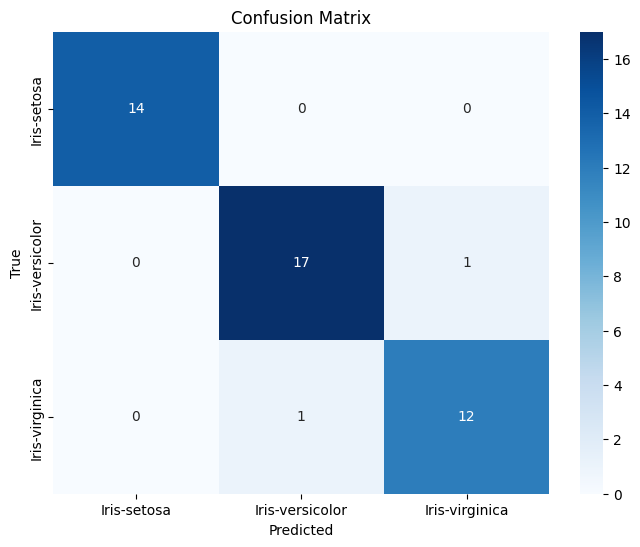

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['type'].unique(), yticklabels=df['type'].unique())

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



##Visualization

In [78]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

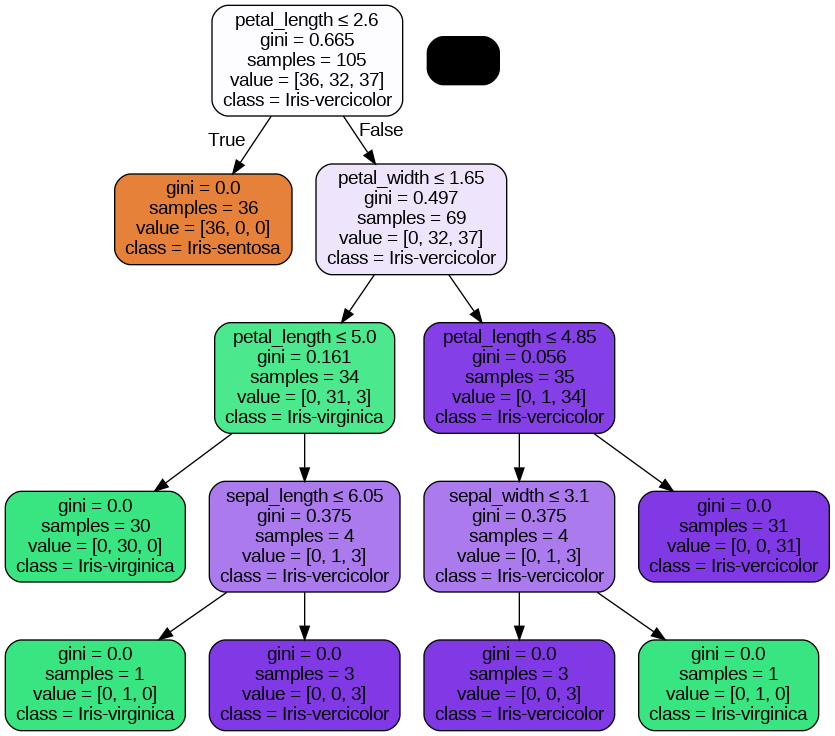

In [79]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Iris-sentosa','Iris-virginica', 'Iris-vercicolor'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('iris.png')
Image(graph.create_png())

Prediction using Entropy Method

In [80]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", splitter="random", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9111111111111111


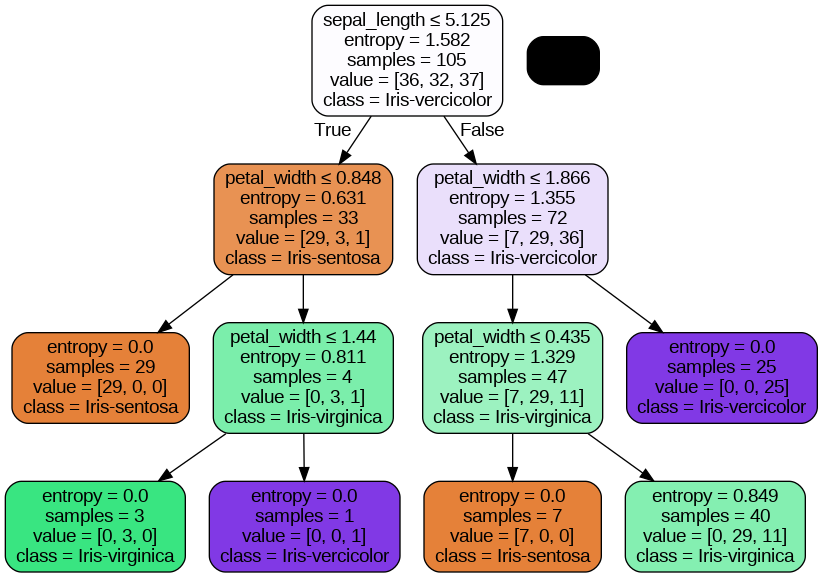

In [81]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Iris-sentosa','Iris-virginica', 'Iris-vercicolor'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('iris.png')
Image(graph.create_png())

##Overfitting on synthetic data set

Use the make_classification() function to define a binary (two class) classification prediction problem with 10,000 examples (rows) and 20 input features (columns).

In [82]:
# evaluate decision tree performance on train and test sets with different tree depths
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

In [83]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(10000, 20) (10000,)


Use the train_test_split() function and split the data into 70 percent for training a model and 30 percent for evaluating it

In [84]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [85]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]

In [86]:
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = DecisionTreeClassifier(max_depth=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.765, test: 0.771
>2, train: 0.805, test: 0.826
>3, train: 0.879, test: 0.890
>4, train: 0.902, test: 0.909
>5, train: 0.912, test: 0.909
>6, train: 0.929, test: 0.923
>7, train: 0.943, test: 0.929
>8, train: 0.948, test: 0.932
>9, train: 0.955, test: 0.932
>10, train: 0.963, test: 0.935
>11, train: 0.969, test: 0.934
>12, train: 0.975, test: 0.933
>13, train: 0.980, test: 0.928
>14, train: 0.985, test: 0.925
>15, train: 0.989, test: 0.928
>16, train: 0.992, test: 0.922
>17, train: 0.995, test: 0.920
>18, train: 0.996, test: 0.918
>19, train: 0.997, test: 0.921
>20, train: 0.997, test: 0.919


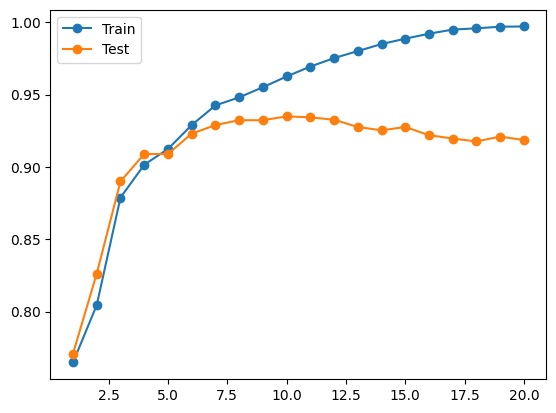

In [87]:
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [88]:

from sklearn.tree import DecisionTreeClassifier

# Train a deep decision tree (Overfitting case)
deep_tree = DecisionTreeClassifier(max_depth=None)  # No depth limit
deep_tree.fit(X_train, y_train)
print("Deep Tree Accuracy:", deep_tree.score(X_test, y_test))

# Train a pruned decision tree (Less overfitting)
pruned_tree = DecisionTreeClassifier(max_depth=3)  # Limited depth
pruned_tree.fit(X_train, y_train)
print("Pruned Tree Accuracy:", pruned_tree.score(X_test, y_test))


Deep Tree Accuracy: 0.9213333333333333
Pruned Tree Accuracy: 0.89


car prediction data set  - decision regressor


In [89]:
print(data.columns)


Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type'], dtype='object')


In [90]:
print(data.head())  # Check dataset preview


   sepal_length  sepal_width  petal_length  petal_width         type
1           5.1          3.5           1.4          0.2  Iris-setosa
2           4.9          3.0           1.4          0.2  Iris-setosa
3           4.7          3.2           1.3          0.2  Iris-setosa
4           4.6          3.1           1.5          0.2  Iris-setosa
5           5.0          3.6           1.4          0.2  Iris-setosa


MAE: 8495.966239509191
RMSE: 18655.36340215665
R² Score: 0.8539910358075516


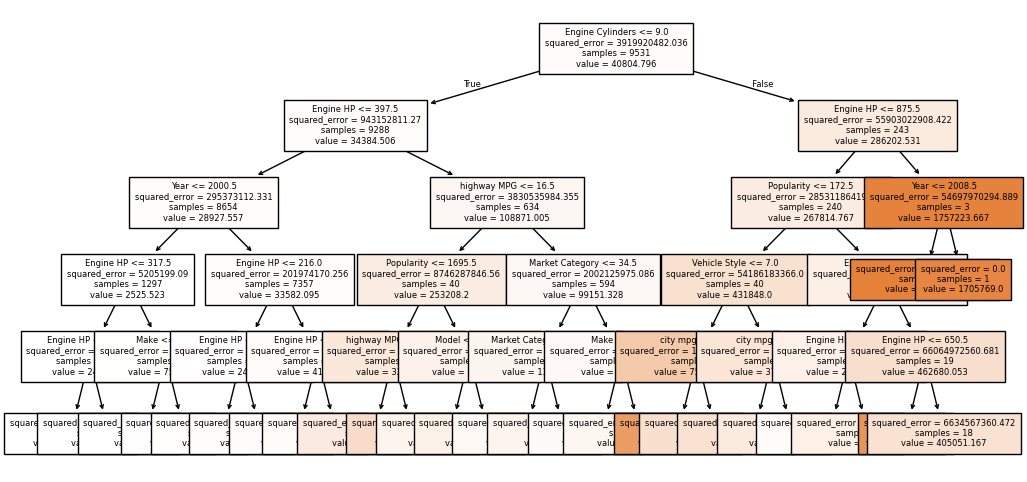

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset & preprocess
df = pd.read_csv("/content/carprediction.csv")
df.columns = df.columns.str.strip()
X, y = df.drop(columns=['MSRP']), df['MSRP']

# Encode categorical variables
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train & Predict
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R² Score: {r2_score(y_test, y_pred)}")

# Plot Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X.columns, filled=True, fontsize=6)
plt.show()
